## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import gym
from collections import deque
from scipy.special import softmax

## Replay Buffer

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append([action])
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append([done])

        return np.array(state_batch), np.array(action_batch), np.array(reward_batch), np.array(next_state_batch), np.array(done_batch)

    def __len__(self):
        return len(self.buffer)

cpu


## Policies

In [4]:
# Epsilon greedy
def choose_action_epsilon(Q, num_actions, epsilon, seed=0):
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(num_actions)
    else:
        action = torch.argmax(Q).item()
    return action

# Softmax
def choose_action_softmax(Q, num_actions, tau, seed=0):
    Q_actions = Q.detach().cpu().numpy()
    probs = softmax(Q_actions/tau)
    action = np.random.choice([i for i in range(num_actions)], p=probs)
    return action

## Neural Network

### Type 1

In [5]:
class Dueling_DQN_T1(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_common = 64, hidden_dim_adv = 256, hidden_dim_val = 256):
        super(Dueling_DQN_T1, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_common = hidden_dim_common
        self.hidden_dim_adv = hidden_dim_adv
        self.hidden_dim_val = hidden_dim_val

        self.fc_common = nn.Linear(self.input_dim, self.hidden_dim_common)
        self.fc_val = nn.Linear(self.hidden_dim_common, self.hidden_dim_val)
        self.fc_adv = nn.Linear(self.hidden_dim_common, self.hidden_dim_adv)

        self.value_layer = nn.Linear(self.hidden_dim_val, 1)
        self.adv_layer = nn.Linear(self.hidden_dim_adv, self.output_dim)

    def forward(self, x):
        x = F.relu(self.fc_common(x))
        self.advantage = self.adv_layer(F.relu(self.fc_adv(x)))
        self.value = self.value_layer(F.relu(self.fc_val(x)))

        self.q = self.value + self.advantage - self.advantage.mean() # type 1

        return self.q

In [7]:
class Dueling_DQN_Agent_T1:
    def __init__(self, env, learning_rate=1e-4, gamma=0.99, tau=1e-2, max_memory_size=50000, seed = 0):

        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.tau = tau
        self.seed = seed
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        self.Q = Dueling_DQN_T1(self.num_states, self.num_actions).to(device)
        self.Q_target = Dueling_DQN_T1(self.num_states, self.num_actions).to(device)
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=learning_rate)

        self.memory = Memory(max_memory_size)

        for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        self.loss_criterion  = nn.MSELoss()

    def get_action(self, state, epsilon, policy = choose_action_softmax):
        q_values = self.Q(torch.Tensor(state).to(device))
        return policy(q_values, self.num_actions, epsilon)

    def update(self, batch_size, episode):
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(np.array(dones).astype(np.uint8)).to(device)

        self.optimizer.zero_grad()
        with torch.no_grad():
            Q_targets_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected = self.Q(states).gather(1, actions.long())

        loss = self.loss_criterion(Q_targets, Q_expected)
        loss.backward()
        self.optimizer.step()

        # copying weights from Q to Q_target
        if episode % 20 == 0:
            for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
                target_param.data.copy_(param.data)

        # polyak averaging
        # for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
        #         target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

### Type 2

In [8]:
class Dueling_DQN_T2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_common = 64, hidden_dim_adv = 256, hidden_dim_val = 256):
        super(Dueling_DQN_T2, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_common = hidden_dim_common
        self.hidden_dim_adv = hidden_dim_adv
        self.hidden_dim_val = hidden_dim_val

        self.fc_common = nn.Linear(self.input_dim, self.hidden_dim_common)
        self.fc_val = nn.Linear(self.hidden_dim_common, self.hidden_dim_val)
        self.fc_adv = nn.Linear(self.hidden_dim_common, self.hidden_dim_adv)

        self.value_layer = nn.Linear(self.hidden_dim_val, 1)
        self.adv_layer = nn.Linear(self.hidden_dim_adv, self.output_dim)

    def forward(self, x):
        x = F.relu(self.fc_common(x))
        self.advantage = self.adv_layer(F.relu(self.fc_adv(x)))
        self.value = self.value_layer(F.relu(self.fc_val(x)))

        self.q = self.value + self.advantage - torch.max(self.advantage) # type 2

        return self.q

In [9]:
class Dueling_DQN_Agent_T2:
    def __init__(self, env, learning_rate=1e-4, gamma=0.99, tau=1e-2, max_memory_size=50000, seed = 0):

        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.tau = tau
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        self.Q = Dueling_DQN_T2(self.num_states, self.num_actions).to(device)
        self.Q_target = Dueling_DQN_T2(self.num_states, self.num_actions).to(device)
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=learning_rate)

        self.memory = Memory(max_memory_size)

        for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        self.loss_criterion  = nn.MSELoss()

    def get_action(self, state, epsilon, policy = choose_action_softmax):
        q_values = self.Q(torch.Tensor(state).to(device))
        return policy(q_values, self.num_actions, epsilon)

    def update(self, batch_size, episode):
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(np.array(dones).astype(np.uint8)).to(device)

        self.optimizer.zero_grad()
        with torch.no_grad():
            Q_targets_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected = self.Q(states).gather(1, actions.long())

        loss = self.loss_criterion(Q_targets, Q_expected)
        loss.backward()
        self.optimizer.step()

        # copying weights from Q to Q_target
        if episode % 20 == 0:
            for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
                target_param.data.copy_(param.data)

        # polyak averaging
        # for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
        #     target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

## Training

In [13]:
def train(env, agent, num_episodes, batch_size, env_threshold, epsilon = 1.0, epsilon_min = 0.01, epsilon_decay = 1, seed = 0, policy = choose_action_softmax):
    rewards = []
    scores_window = deque(maxlen=100)
    eps = epsilon

    for episode in range(num_episodes):
        state = env.reset(seed=seed)
        score = 0
        for i in range(500):
            action = agent.get_action(state, eps, policy = policy)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if len(agent.memory) > batch_size:
                agent.update(batch_size, episode)
            if done:
                break

        scores_window.append(score)
        rewards.append(score)

        eps = max(epsilon_min, epsilon_decay*eps)

        print('\rEpisode {}\tScore: {:.2f}'.format(episode, score), end="")

        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))

        # if np.mean(scores_window)>=env_threshold:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        #     break

    return rewards

## Cartpole

### Type 1

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Average Score: 9.00
Episode 100	Average Score: 19.69
Episode 200	Average Score: 112.67
Episode 300	Average Score: 178.92
Episode 400	Average Score: 177.04
Episode 499	Score: 201.00

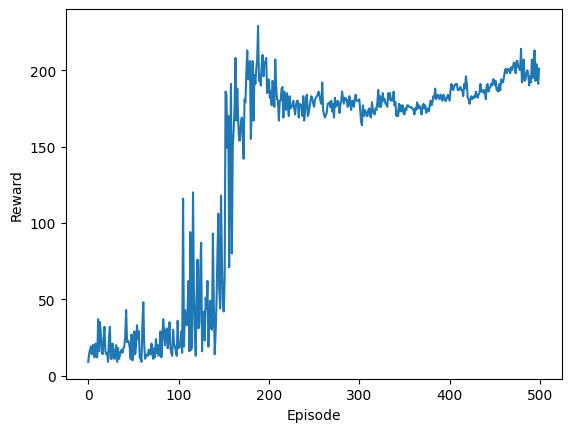

In [15]:
env = gym.make('CartPole-v1')
# env.seed(0)

agent = Dueling_DQN_Agent_T1(env, learning_rate=1e-4, gamma=0.99, tau=1e-2, seed = 0)

reward = train(env, agent, num_episodes=500, batch_size=64, env_threshold=195, epsilon=1.0, seed = 0, policy = choose_action_softmax)

plt.plot(reward)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Type 2

Episode 0	Average Score: 9.00
Episode 100	Average Score: 22.24
Episode 200	Average Score: 64.70
Episode 300	Average Score: 178.79
Episode 400	Average Score: 175.08
Episode 499	Score: 175.00

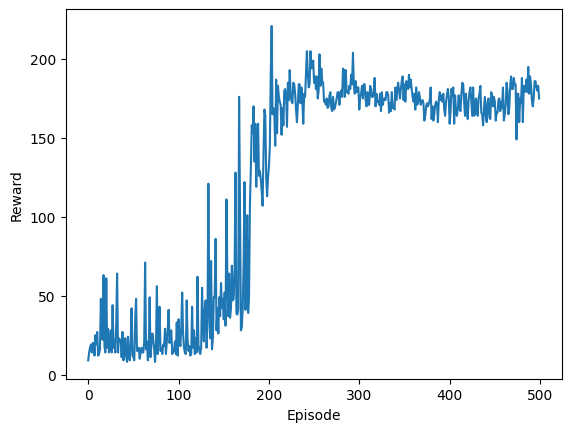

In [16]:
env = gym.make('CartPole-v1')
# env.seed(0)

agent = Dueling_DQN_Agent_T2(env, learning_rate=1e-4, gamma=0.99, tau=1e-2, seed = 0)

reward = train(env, agent, num_episodes=500, batch_size=64, env_threshold=195, epsilon=1.0, seed = 0, policy = choose_action_softmax)

plt.plot(reward)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Type 1 and Type 2

### Multiple Runs

In [17]:
reward_type1 = []

for i in range(1, 6):
    seed = i
    env = gym.make('CartPole-v1')
    agent = Dueling_DQN_Agent_T1(env, learning_rate=1e-4, gamma=0.99, tau=1e-2, seed = seed)

    reward = train(env, agent, num_episodes=500, batch_size=64, env_threshold=195, epsilon=1, epsilon_min=0.0001, epsilon_decay=1, seed = seed, policy = choose_action_softmax)
    reward_type1.append(np.array(reward))

Episode 0	Average Score: 12.00
Episode 100	Average Score: 22.75
Episode 200	Average Score: 140.17
Episode 300	Average Score: 242.75
Episode 400	Average Score: 225.71
Episode 0	Average Score: 11.00
Episode 100	Average Score: 22.22
Episode 200	Average Score: 183.62
Episode 300	Average Score: 292.88
Episode 400	Average Score: 268.42
Episode 0	Average Score: 42.00
Episode 100	Average Score: 20.66
Episode 200	Average Score: 120.77
Episode 300	Average Score: 202.44
Episode 400	Average Score: 199.01
Episode 0	Average Score: 33.00
Episode 100	Average Score: 21.64
Episode 200	Average Score: 105.05
Episode 300	Average Score: 223.34
Episode 400	Average Score: 221.96
Episode 0	Average Score: 53.00
Episode 100	Average Score: 20.36
Episode 200	Average Score: 107.05
Episode 300	Average Score: 271.49
Episode 400	Average Score: 251.31
Episode 499	Score: 352.00

In [18]:
reward_type2 = []

for i in range(1, 6):
    seed = i
    env = gym.make('CartPole-v1')
    agent = Dueling_DQN_Agent_T2(env, learning_rate=1e-4, gamma=0.99, tau=1e-2, seed = seed)

    reward = train(env, agent, num_episodes=500, batch_size=64, env_threshold=195, epsilon=1, epsilon_min=0.0001, epsilon_decay=1, seed = seed, policy = choose_action_softmax)
    reward_type2.append(np.array(reward))

Episode 0	Average Score: 12.00
Episode 100	Average Score: 23.31
Episode 200	Average Score: 93.76
Episode 300	Average Score: 265.08
Episode 400	Average Score: 218.57
Episode 0	Average Score: 11.00
Episode 100	Average Score: 21.13
Episode 200	Average Score: 93.87
Episode 300	Average Score: 236.97
Episode 400	Average Score: 231.93
Episode 0	Average Score: 42.00
Episode 100	Average Score: 20.44
Episode 200	Average Score: 101.40
Episode 300	Average Score: 197.34
Episode 400	Average Score: 205.19
Episode 0	Average Score: 33.00
Episode 100	Average Score: 19.56
Episode 200	Average Score: 65.91
Episode 300	Average Score: 155.08
Episode 400	Average Score: 163.90
Episode 0	Average Score: 53.00
Episode 100	Average Score: 20.97
Episode 200	Average Score: 69.51
Episode 300	Average Score: 254.36
Episode 400	Average Score: 231.47
Episode 499	Score: 221.00

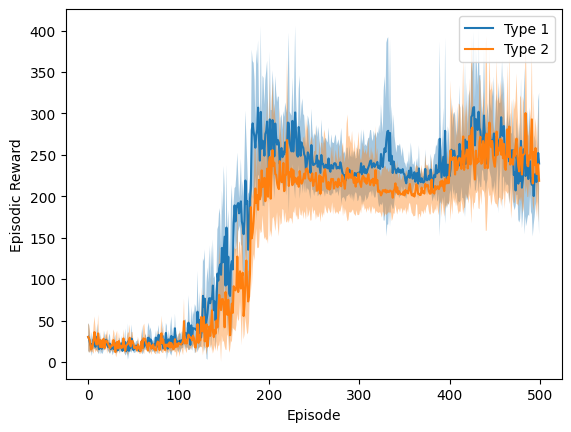

In [19]:
reward_type1 = np.array(reward_type1)
reward_std_type1 = np.std(reward_type1, axis=0)
reward_avgs_type1 = np.mean(reward_type1, axis=0)

reward_type2 = np.array(reward_type2)
reward_std_type2 = np.std(reward_type2, axis=0)
reward_avgs_type2 = np.mean(reward_type2, axis=0)

plt.figure()
plt.plot(reward_avgs_type1, label='Type 1')
plt.fill_between(np.array(range(500)), reward_avgs_type1 - reward_std_type1, reward_avgs_type1 + reward_std_type1, alpha=0.4)
plt.plot(reward_avgs_type2, label = 'Type 2')
plt.fill_between(np.array(range(500)), reward_avgs_type2 - reward_std_type2, reward_avgs_type2 + reward_std_type2, alpha=0.4)
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('cartpole_config_final.png')
plt.show()

In [20]:
print(f"Regret for Type 1 = {np.sum(np.array([500 for i in range(500)]) - reward_avgs_type1)}")
print(f"Regret for Type 2 = {np.sum(np.array([500 for i in range(500)]) - reward_avgs_type2)}")

Regret for Type 1 = 161588.6
Regret for Type 2 = 171373.4


## Acrobot

### Type 1

Episode 0	Average Score: -500.00
Episode 100	Average Score: -372.48
Episode 200	Average Score: -283.47
Episode 300	Average Score: -230.79
Episode 400	Average Score: -191.32
Episode 500	Average Score: -227.49
Episode 600	Average Score: -224.81
Episode 700	Average Score: -193.93
Episode 800	Average Score: -198.48
Episode 900	Average Score: -206.15
Episode 999	Score: -172.00

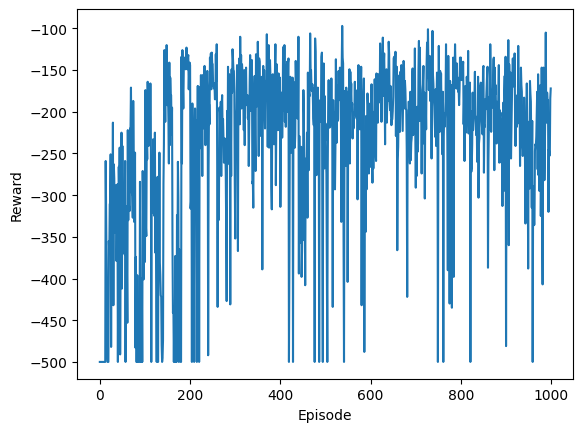

In [21]:
env = gym.make('Acrobot-v1')

agent = Dueling_DQN_Agent_T1(env, learning_rate=1e-3, gamma=0.99, tau=1e-2, seed = 0)

reward = train(env, agent, num_episodes=1000, batch_size=64, env_threshold=-100, epsilon = 1, seed = 0, policy = choose_action_softmax)

plt.plot(reward)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Type 2

Episode 0	Average Score: -456.00
Episode 100	Average Score: -390.70
Episode 200	Average Score: -284.21
Episode 300	Average Score: -217.84
Episode 400	Average Score: -217.08
Episode 500	Average Score: -211.87
Episode 600	Average Score: -250.53
Episode 700	Average Score: -209.21
Episode 800	Average Score: -222.13
Episode 900	Average Score: -201.03
Episode 999	Score: -385.00

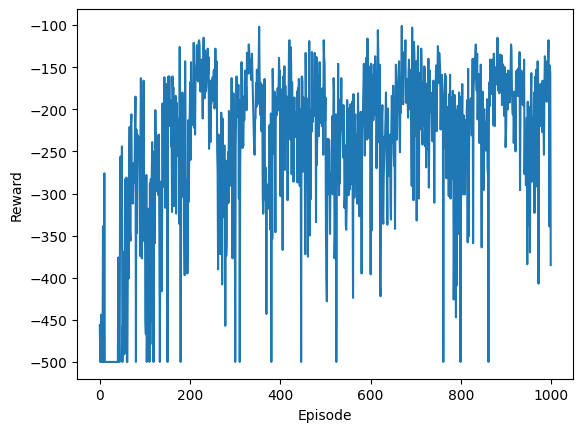

In [22]:
env = gym.make('Acrobot-v1')

agent = Dueling_DQN_Agent_T2(env, learning_rate=1e-3, gamma=0.99, tau=1e-2, seed = 0)

reward = train(env, agent, num_episodes=1000, batch_size=64, env_threshold=-100, epsilon =1, seed = 0, policy = choose_action_softmax)

plt.plot(reward)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Type 1 and Type 2

### Multiple Runs

In [24]:
reward_type1 = []

for i in range(5):
    seed = i
    env = gym.make('Acrobot-v1')
    agent = Dueling_DQN_Agent_T1(env, learning_rate=1e-3, gamma=0.99, tau=1e-2, seed = seed)

    reward = train(env, agent, num_episodes=1000, batch_size=64, env_threshold=195, epsilon= 1, epsilon_min=0.0001, epsilon_decay=1, seed = seed, policy = choose_action_softmax)
    reward_type1.append(np.array(reward))

Episode 0	Average Score: -500.00
Episode 100	Average Score: -372.48
Episode 200	Average Score: -283.47
Episode 300	Average Score: -230.79
Episode 400	Average Score: -191.32
Episode 500	Average Score: -227.49
Episode 600	Average Score: -224.81
Episode 700	Average Score: -193.93
Episode 800	Average Score: -198.48
Episode 900	Average Score: -206.15
Episode 0	Average Score: -500.00
Episode 100	Average Score: -410.43
Episode 200	Average Score: -300.97
Episode 300	Average Score: -240.18
Episode 400	Average Score: -233.95
Episode 500	Average Score: -200.76
Episode 600	Average Score: -227.62
Episode 700	Average Score: -201.58
Episode 800	Average Score: -197.44
Episode 900	Average Score: -219.31
Episode 0	Average Score: -500.00
Episode 100	Average Score: -409.28
Episode 200	Average Score: -264.47
Episode 300	Average Score: -216.55
Episode 400	Average Score: -223.90
Episode 500	Average Score: -200.78
Episode 600	Average Score: -235.18
Episode 700	Average Score: -235.50
Episode 800	Average Score:

In [25]:
reward_type2 = []

for i in range(5):
    seed = i
    env = gym.make('Acrobot-v1')
    agent = Dueling_DQN_Agent_T2(env, learning_rate=1e-3, gamma=0.99, tau=1e-2, seed = seed)

    reward = train(env, agent, num_episodes=1000, batch_size=64, env_threshold=195, epsilon=1, epsilon_min=0.0001, epsilon_decay=1, seed = seed, policy = choose_action_softmax)
    reward_type2.append(np.array(reward))

Episode 0	Average Score: -456.00
Episode 100	Average Score: -390.70
Episode 200	Average Score: -284.21
Episode 300	Average Score: -217.84
Episode 400	Average Score: -217.08
Episode 500	Average Score: -211.87
Episode 600	Average Score: -250.53
Episode 700	Average Score: -209.21
Episode 800	Average Score: -222.13
Episode 900	Average Score: -201.03
Episode 0	Average Score: -500.00
Episode 100	Average Score: -318.47
Episode 200	Average Score: -235.52
Episode 300	Average Score: -295.37
Episode 400	Average Score: -234.46
Episode 500	Average Score: -228.23
Episode 600	Average Score: -251.96
Episode 700	Average Score: -221.76
Episode 800	Average Score: -194.53
Episode 900	Average Score: -180.09
Episode 0	Average Score: -500.00
Episode 100	Average Score: -371.12
Episode 200	Average Score: -228.54
Episode 300	Average Score: -254.88
Episode 400	Average Score: -233.56
Episode 500	Average Score: -262.58
Episode 600	Average Score: -323.86
Episode 700	Average Score: -262.53
Episode 800	Average Score:

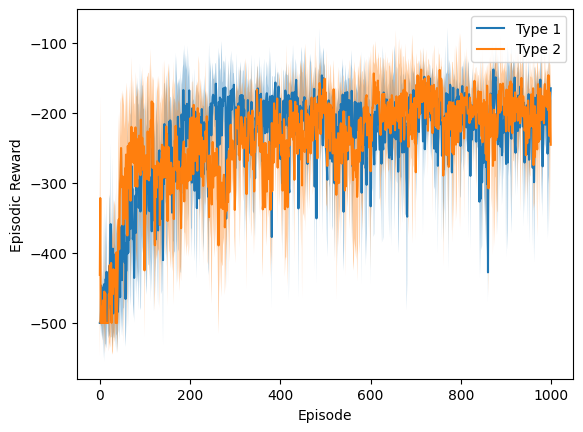

In [26]:
reward_type1 = np.array(reward_type1)
reward_std_type1 = np.std(reward_type1, axis=0)
reward_avgs_type1 = np.mean(reward_type1, axis=0)

reward_type2 = np.array(reward_type2)
reward_std_type2 = np.std(reward_type2, axis=0)
reward_avgs_type2 = np.mean(reward_type2, axis=0)

plt.figure()
plt.plot(reward_avgs_type1, label='Type 1')
plt.fill_between(np.array(range(len(reward_avgs_type1))), reward_avgs_type1 - reward_std_type1, reward_avgs_type1 + reward_std_type1, alpha=0.4)
plt.plot(reward_avgs_type2, label = 'Type 2')
plt.fill_between(np.array(range(len(reward_avgs_type2))), reward_avgs_type2 - reward_std_type2, reward_avgs_type2 + reward_std_type2, alpha=0.4)
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.legend()
plt.savefig('acrobot_config_final.png')
plt.show()

In [27]:
print(f"Regret for Type 1 = {np.sum(np.zeros(1000) - reward_avgs_type1)}")
print(f"Regret for Type 2 = {np.sum(np.zeros(1000) - reward_avgs_type2)}")

Regret for Type 1 = 239167.40000000002
Regret for Type 2 = 240640.40000000002
